In [1]:
import os
from typing import Tuple, List, Iterable, Callable

import math
import time
import numpy as np
import pandas as pd
from scipy.stats import halfcauchy, invgamma
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy import stats

from scipy.stats import multivariate_normal
from numpy.random import default_rng
from itertools import chain, combinations, product

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)

In [2]:
# For Testing only
from sklearn.datasets import make_spd_matrix
import numpy as np
import cvxpy as cvx
from itertools import combinations

## utils.py

In [3]:
def powerset(x:Iterable):
    '''
    Powerset (set of subsets) for a given iterable x incl. ∅
    '''
    s = list(x)
    powerSet = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
    return list(powerSet)

## models.py

`Oracle`: 
- **TODO** Proper management of access counts (`N_total` ?)
- clarify roles of `N_total` and `N_current`
- consider how to incorporate `seedVal` to  function call `f`

In [4]:
class MaxQueriesExceeded(Exception):
    def __init__(self, message):            
        # Call the base class constructor with the parameters it needs
        super().__init__(message)
        
        

class Oracle:
    def __init__(self, fun, order:int=2, sigma_2:float=0.0, N_total:int=1000, seed:int=0):
        '''
        Noise terms are sampled at initialization to s.t. sampled function values f(x_i) are 
        reporducible regardless how the oracle is sampled.
        '''
        assert isinstance(fun, Callable), "Input `f` must be a callable function."
        assert isinstance(order, int) and 1<=order<6, "Maximum `order` of interaction terms should be 5."
        assert isinstance(sigma_2, float) and sigma_2>=0, "Noise variance parameter `sigma_2` must be a non-negative float."
        assert isinstance(seed, int), "Seed for random draws `seed` must be an integer."
        assert isinstance(N_total, int), "Maximum number of queries `N_total` must be an positive integer."
        
        self.fun = fun
        self.order = order
        self.sigma_2 = sigma_2
        self.seed = seed
        self.N_total = N_total
        self.N_current = 0
        
        if(self.sigma_2 > 0):
            np.random.seed(self.seed)
            self.eps = np.random.normal(loc=0, scale=np.sqrt(self.sigma_2), size=self.N_total)
        else:
            self.eps = np.zeros(self.N_total)
    
    def __expandX__(self, x:np.array) -> np.array:
        '''
        Expand a binary input vector `x` from the original input format with indices {1,...,d} to
        {0} (intercept), {1,...,d} (1st-order coefs), {... (d over 2) ... } (2nd-order effects)
        '''
        
        # 
        matrixInput = len(x.shape)==2 and len(x)>1
        
        # transform
        if(matrixInput):
            highOrdMats = [np.ones(len(x)).reshape(-1,1), x]
            # o-th order : CORRECT
            for o in range(2, self.order+1):
                highOrdMats.append(np.stack([np.prod([x[:,pair[i]] for i in range(o)], axis=0) for pair in powerset(range(x.shape[1])) if len(pair)==o], axis=1))

            #print('highOrdMats : ', highOrdMats)
            x = np.concatenate(highOrdMats, axis=1)
        else:
            # o-th order : CORRECT
            x = np.array(x, dtype=np.float64)
            highOrdMats = [x]
            for o in range(2, self.order+1):
                highOrdMats.append(np.array([np.prod([x[pair[i]] for i in range(o)]) for pair in powerset(range(len(x))) if len(pair)==o]))

            #print(highOrdMats)
            x = np.concatenate(([np.array([1])] + highOrdMats), axis=0)
        
        return x
    
    def f(self, x:np.array):
        '''
        Returns (noisy) function value f(x). 
        If `noiseFlag` is set to True, f(x) + eps with eps ~ N(f(x), sigma_2) is returned.
        '''
    
        # expand raw input
        #x = self.__expandX__(x)
        
        matInputFlag = len(x.shape)==2 and len(x)>1
        
        # check if within remaining query budget
        n_req = len(x) if matInputFlag else 1
        
        if(self.N_current + n_req > self.N_total):
            raise MaxQueriesExceeded(f"Maximum number of queries `N_total`={self.N_total} would be exceeded with these `n_req`={n_req} additional requests given that `N_current=`{self.N_current}.")
        
        # compute (noisy) function value
        if(matInputFlag):
            fx =  self.fun(x) + self.eps[self.N_current:self.N_current+len(x)] if (self.sigma_2 > 0) else np.zeros(len(x))
        else:
            fx =  self.fun(x) + (float(self.eps[self.N_current]) if (self.sigma_2 > 0) else 0)
        
        # update budget
        self.N_current += n_req
        
        return fx
        

## `sklearn` as a reference

How & what errors/exceptions are being triggered

`lm.fit(X=4,y=4)`

```
ValueError: Expected 2D array, got scalar array instead: array=4.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample
```

`X is singul`
No 
```
LinAlgError: Singular matrix
``` 
is being triggered. `LinearModel` has numerical routines to circumvent this.

Setting a value, e.g. `lm.coef_+5`
No exception is being triggered (of course).

In [5]:
# init object
lm = LinearRegression()

# data
n, k = 100, 5
np.random.seed(3457)
X = np.random.normal(loc=1,scale=1.5,size=n*k).reshape(n,-1)
y = (2.5*X).sum(axis=1) + np.random.normal(loc=0,scale=0.5,size=n).flatten() + 5

# fit
lm.fit(X,y) 

LinearRegression()

## Test `Oracle`

In [6]:
o1 = Oracle(fun=lambda x: np.sum(x, axis=1), sigma_2=0.0, N_total=2000, seed=777, order=3)

X = np.array([[0, 3, 4], [1, 1, 2], [3, 3, 4]])
#X = np.random.normal(loc=0, scale=2, size=10 * 3).reshape(-1, 3)

# show
print(X)

y = o1.fun(X)

[[0 3 4]
 [1 1 2]
 [3 3 4]]


In [7]:
class SparseBayesReg:
    def __init__(self, N_total:int, order:int=2, seed:int=0, burnin:int=0, thinning:int=1, d_MAX:int=10):

        assert isinstance(seed, int), "`seed` must be an integer."
        assert isinstance(burnin, int) and burnin>=0, "`burnin` must be a non-negative integer."
        assert isinstance(thinning, int) and thinning>=1, "`thinning` must be an positive integer."
        
        # - assignment
        self.N_total = N_total
        self.order = order
        self.seed = seed
        self.burnin = burnin
        self.thinning = thinning
        self.d_MAX = d_MAX
        
    def setXy(self, X:np.array, y:np.array) -> None:
        '''
        Setup of design matrix X (standardized, incl. leading 1-column and quadratic terms) and target vector y (transalted to E[y]=0)
        '''
        assert sum(X[:,0])!=len(X), "Provide the design matrix X without adding a leading 1-column (for intercept)"
        
        self.d = X.shape[1]
        self.p = sum([math.comb(self.d, k) for k in range(0,self.order+1)])
        
        assert isinstance(self.d, int) and 0<self.d<=self.d_MAX, f"The inferred dimension `d`={self.d} should be smaller than {self.d_MAX}"
        
        X = self.__expandX__(X)         # arbitrary interaction effects of order k
        X = self.__standardizeX__(X)
        X = self.__interceptColumnX__(X)
        self.X = X
        
        #y = self.__translateY__(y)  # TEST
        self.y = y
        
    def setX(self, X:np.array) -> None:
        '''
        Setup of design matrix X(_new) for prediction only.
        '''
        assert sum(X[:,0])!=len(X), "Provide the design matrix X without adding a leading 1-column (for intercept)"
        assert X.shape[1]==self.d, f"Input matrix `X` has {X.shape[1]} columns but {self.d} was expected. Provide input with original dimension `d`."

        X = self.__expandX__(X)
        X = self.__standardizeX__(X, trainMode=False)
        X = self.__interceptColumnX__(X)
        
        return X
    
    def __expandX__(self, X:np.array) -> None:
        '''
        Given a (binary) design matrix X, it appends pairwise products of columns and appends to the design matrix X;
        *excluding* the leading intercept column of 1's
        '''
        
        assert self.order<=X.shape[1], f"`Order` of interaction terms can be at most number of columns of design matrix `X`. Lower the `order` to `X.shape[1]`={X.shape[1]}."
        if(self.order==X.shape[1]):
            raise np.linalg.LinAlgError("Setting `order` equal to the number of columns of the design matrix will cause parameters to be unidentifiable.")
        
        # append to arbitrary terms
        xList = [X]
        # o-th order : CORRECT
        for k in range(2, self.order+1):
            xList.append(np.stack([np.prod([X[:,pair[i]] for i in range(k)], axis=0) for pair in powerset(range(X.shape[1])) if len(pair)==k], axis=1))

        #print('highOrdMats : ', highOrdMats)
        X = np.concatenate(xList, axis=1)
        
        return X

    def __standardizeX__(self, X:np.array, trainMode:bool=True) -> None:
        '''
        Standardizes (translates & rescales) the columns of the design matrix (input matrix) 
        '''

        assert X.shape[1]==self.p-1, "The given design matrix includes a leading 1-column; unclear if it is a legitimiate (coincidental) feature or leading 1 column was already incldued"

        if(trainMode):
            X_mu, X_sigma = X.mean(axis=0), X.std(axis=0)
            self.X_mu = X_mu
            self.X_sigma = X_sigma  #np.sqrt(len(X)) * X_sigma  # corrected for sqrt(n)
        else:
            assert (self.X_mu is not None) and (self.X_sigma is not None), "`X_mu` and `X_sigma` must be pre-computed."
        
        X = (X - self.X_mu) / self.X_sigma
        
        return X
        
    def __interceptColumnX__(self, X:np.array) -> np.array:
        '''
        Adds a leading vector of 1s to the binary matrix X (of 1st and 2nd order interactions)
        '''
        
        X = np.concatenate((np.ones_like(X[:,0]).reshape(-1,1), X), axis=1)

        assert X.shape[1]==self.p, "Inconsistent number of columns after adding leading 1-col"
        
        return X

    def __translateY__(self, y:np.array, trainMode:bool=True) -> None:
        '''
        Translation of the target vector y such that priori condition E[y]=0 is satisfied.
        (No rescaling to unit variance is applied, though.)
        '''
        X = self.X

        assert len(X) == len(y), "Length of target vector y does not coincide with design matrix X"

        # Standardize y's
        if(trainMode):
            self.y_mu = np.mean(y)
        else:
            assert self.y_mu, "`y_mu` must be computed."
        
        # translation
        y = y - self.y_mu
        
        return y
        
    def add(self, X:np.array, y:float, fitFlag:bool=True) -> None:
        '''
        Appends new datapoint to X,y
        '''
        
        # YYY
        assert isinstance(X, np.ndarray), "New data `X` must be provided as a numpy array."
        
        # convert obs. vector (n=1)
        if len(X.shape)==1:
            X = X.reshape(1, len(X))
            if(isinstance(y, float) or isinstance(y, int)):
                y = np.array([y])
        
        assert X.shape[1]==self.d, "New data input should have column dim. `d`."
        assert len(X)==len(y), "Lengths of new data `X` and `y` do not coincide."
        
        # New
        #X = self.__expandX__(X)
        #X = self.__standardizeX__(X, trainMode=False)
        #X = self.__interceptColumnX__(X)
        
        # Newer
        X = self.setX(X)
        
        assert self.X.shape[1]==X.shape[1], "Number of columns of new data must coincide with design matrix `X`."
        
        # append to data
        self.X = np.concatenate((np.array(self.X), X), axis=0)
        self.y = np.concatenate((np.array(self.y), y), axis=0)
        
        # re-fit
        if(fitFlag):
            self.__fit__()
            
        return None
    
    def __mvg__(self, Phi, alpha, D):
        '''
        Sample multivariate Gaussian (independent of d) from NumPy
        Not used Rue (2001) or et. al. (2015) approaches on fast sampling mvg
        N(mean = S@Phi.T@y, cov = inv(Phi'Phi + inv(D))
        '''
        #assert len(Phi.shape)==2 and Phi.shape[0]==Phi.shape[1], "`Phi` must be a quadratic matrix."
        assert len(D.shape)==2 and D.shape[0]==D.shape[1], "`D` must be a quadratic matrix."
        
        S = np.linalg.inv(Phi.T @ Phi + np.linalg.inv(D))
        x = np.random.multivariate_normal(mean=((S @ Phi.T) @ y), cov=S, size=1)
        
        return x
    
    def sampleStandardizedAlpha(self, ) -> np.array:
        '''
        Samples posterior  ~ P( |X_tilde,y) from (most current) posterior distribution 
        parametrized by the standardized design matrix X_tilde.
        '''
        
        assert (self.alpha_mu is not None) and (self.alpha_cov is not None), "Posterior mean and covariance not available yet as the model been computed yet. Run `.fit(X,y)`."
        
        alpha_post = np.random.multivariate_normal(mean = self.alpha_mu,
                                                   cov  = self.alpha_cov,
                                                   size = 1).reshape(-1)
        
        return alpha_post

    def sampleAlpha(self, ) -> np.array:
        '''
        Samples posterior  ~ P( |X,y) from (most current) posterior distribution 
        parametrized by the design matrix X.
        '''
        
        alpha_post = np.array(self.sampleStandardizedAlpha())
        
        # correct w.r.t. X_tilde = (X - X_mu) / X_sigma
        alpha_post[1:] /= self.X_sigma
        alpha_post[0]  -= self.X_mu @ alpha_post[1:] 
        
        return alpha_post
    
    def getMeanStandardizedAlpha(self, ) -> np.array:
        '''
        Posterior mean of alpha based on the row-wise standardized design matrix X_tilde
        '''
        
        return np.array(self.alpha_mu)
    
    def getMeanAlpha(self, ) -> np.array:
        '''
        Posterior mean of alpha based on the (actual) design matrix X.
        '''
        alpha_mu = np.array(self.getMeanStandardizedAlpha())
        
        # correct w.r.t. X_tilde = (X - X_mu) / X_sigma
        alpha_mu[1:] /= self.X_sigma
        alpha_mu[0]  -= self.X_mu @ alpha_mu[1:]  
        
        return alpha_mu
    
    # sbr.X_mu @ sbr.getMeanAlpha()[1:]
    
    def __fit__(self) -> None:
        '''
        Core of fitting procedure (on self.X, self.y)
        '''
        
        # TEST
        print(f'self.p : {self.p}')
        
        # D0
        self.n = len(self.X)
        
        # setup values
        alphas_out = np.zeros((self.p, 1))
        s2_out     = np.zeros((1, 1))
        t2_out     = np.zeros((1, 1))
        l2_out     = np.zeros((self.p, 1))

        # sample priors
        betas   = halfcauchy.rvs(size=self.p) 
        tau_2   = halfcauchy.rvs(size=1)                            
        nu      = np.ones(self.p) # ?
 
        sigma_2, xi = 1.0, 1.0
        
        # Gibbs sampler
        for k in range(self.N_total):
            sigma = np.sqrt(sigma_2)

            # alphas
            # - Sigma_star
            Sigma_star = tau_2 * np.diag(betas**2) # Sigma_star
            Sigma_star_inv = np.linalg.inv(Sigma_star)
            
            # - A
            A     = (self.X.T @ self.X) + Sigma_star_inv
            A_inv = np.linalg.inv(A)
            
            # - update posterior mean, cov
            self.alpha_mu  = A_inv @ self.X.T @ self.y
            self.alpha_cov = sigma_2 * A_inv
            
            # - alpha
            alphas = self.sampleStandardizedAlpha()
            
            # - sigma_2
            sigma_2 = invgamma.rvs(0.5*(self.n+self.p), scale=0.5*(np.linalg.norm((self.y - self.X @ alphas), 2)**2 + (alphas.T @ Sigma_star_inv @ alphas)))

            # - betas
            betas_2 = invgamma.rvs(np.ones(self.p), scale=(1. / nu) + (alphas**2)/(2. * tau_2 * sigma_2))
            betas = np.sqrt(betas_2)

            # - tau_2
            tau_2 = invgamma.rvs(0.5*(self.p+1), scale=1.0 / xi + (1. / (2. * sigma_2)) * sum(alphas**2 / betas**2), size=1)

            # - nu
            nu = invgamma.rvs(np.ones(self.p), scale=1.0 + 1. / betas_2, size=self.p)

            # - xi
            xi = invgamma.rvs(1.0, scale=1.0 + 1. / tau_2, size=1)
            
            # store samples
            if k > self.burnin:
                # - append
                if(k%self.thinning==0):
                    alphas_out = np.append(arr=alphas_out, values=alphas.reshape(-1,1), axis=1)
                    s2_out = np.append(s2_out, sigma_2)
                    t2_out = np.append(t2_out, tau_2)
                    l2_out = np.append(arr=l2_out, values=betas.reshape(-1,1), axis=1)

        # Clip 1st value
        self.alphas = alphas_out[:,1:]
        self.s2 = s2_out[1:]
        self.t2 = t2_out[1:]
        self.l2 = l2_out[1:]
        
    def getStandardizedAlphas(self) -> np.array:
        '''
        Returns current array of alpha posterior samples (based on the standardized design matrix X_tilde)
        '''
        return self.alphas
    
    def fit(self, X:np.array, y:np.array) -> None:
        '''
        Fitting the (initial) model on the data D0={X0,y0}
        '''
        assert len(X.shape)==2 and len(y.shape)==1, "Design matrix X and target vector y."
        assert X.shape[0]==len(y), f"Dimension of design matrix X and target vector y do not coincide: X.shape[1]={X.shape[1]}!={len(y)}=len(y)"
        assert len(X) < self.N_total, f"Implied `N_init`=len(X)={len(X)} exceeds `N_total`={self.N_total}."
        
        # setup
        self.setXy(X, y)
        
        # fitting
        self.__fit__()
        
    def predict(self, X:np.array, mode:str='mean') -> np.array:
        '''
        Obtain prediction
        '''
        assert mode in ['mean', 'post'], "`predict`ion from Bayesian sparse regression either by `mean` (MLE estimator of alpha) or randomly sampled from `post`erior."
        assert X.shape[1] == self.d, f"Format of input matrix wrong. Does not have `d`={self.d} columns but `X.shape[1]`={X.shape[1]}"
        
        # TraFo data
        X = self.setX(X)
        
        # apply model
        alpha_hat = self.getMeanStandardizedAlpha() if mode=='mean' else self.sampleStandardizedAlpha()
        
        # dot prod
        y_hat = X @ alpha_hat
        
        # revsert-translation
        #y_hat = y_hat + self.y_mu # TEST
        
        
        return y_hat

## Test `SparseBayesReg`

- check `fit` ✅
    - model 1 : $f(x) = 5 + \sum_{i=1}^{d} 2 \cdot x_{i}$
    - model 2 : $x^{2}$ ... i.e. $f(x) = 10 + \sum_{i=1}^{d} 2 \cdot x_{i}$
    
- works for various regression models/orders ✅
    
- check `predict` ✅

### Remains to test
- Add a new observation (row) ✅
- Check if refitting works  ✅
    - additionally, allow to decide if adding data triggers re-fit everytime (it shouldn't).  ✅
- optimize how many initial Gibbs sampling runs have to be performed (vs. new gibs runs during re-fitting) `???`

In [8]:
# set data
sbr = SparseBayesReg(N_total=5000, order=2, burnin=100, thinning=2)

# X, y
n, k = 500, 3
X = np.random.normal(0, 3, size=n*k).reshape(n,-1)
f = lambda x: -7 + 3*x[:,0] - 2*x[:,1] - 1*x[:,2] #+ 6*x[:,0]*x[:,1] -9*x[:,1]*x[:,2]
sig_2 = 1.0
y = f(X) + np.random.normal(0,sig_2,size=len(X)).flatten()


# fit model
sbr.fit(X, y) 

# 
alpha = sbr.getMeanAlpha()

self.p : 7


In [9]:
alpha

array([-7.05151747,  2.98021042, -2.00020593, -0.9985819 , -0.00680622,
       -0.00091348, -0.00028615])

In [10]:
# Semi-definite Programming
sdp1 = SDP(alpha=a, lambd=0.1, pen_ord=2, mode='min')

sdp1 

NameError: name 'SDP' is not defined

In [12]:
class SDP:
    def __init__(self, alpha:np.array, lambd:float=0.1, pen_ord:int=2, mode:str='min', d_MAX:int=20) -> List[np.array]:
        
        assert isinstance(mode, str), "Input `mode` must be a either `min` or `max`."
        assert mode in ['min', 'max'], f"Input `mode` is str. In addition, it must be a str either `min` or `max` but `{mode}` was provided."
        assert isinstance(lambd, float) and lambd >=0, "lambda (regularization parameter) must be non-negative scalar."
        assert pen_ord in [1, 2], "Penalty norm order `pen_ord` must be either 1 or 2."
        
        self.mode = mode
        self.lambd = lambd
        self.pen_ord = pen_ord
        self.alpha = alpha
        self.d_MAX = d_MAX
        
        # infer d(imension): possible since only quadratic terms possible
        self.p = len(self.alpha)
        dDict = {1+dLoc+math.comb(dLoc,2) : dLoc for dLoc in range(1,self.d_MAX+1)}
        if(self.p in dDict.keys()):
            self.d = dDict[self.p]
        else:
            assert False, f'Length of `alpha` is not a 1+d+binom(d,2) for any 1,2,...,{self.d_MAX}'
        assert isinstance(self.d, int), "Dimension `d` must be non-negative integer."
        
        # extract 1st/2nd order terms
        b = self.alpha[1:1 + self.d]  # 1st
        a = self.alpha[1 + self.d:]   # 2nd

        # get indices for quadratic terms
        idx_prod = np.array(list(combinations(np.arange(self.d), 2)))
        d_idx = idx_prod.shape[0]

        # check number of coefficients
        if len(a)!=d_idx:
            assert False, 'Number of Coefficients does not match indices!'

        # xAx-term
        A = np.zeros((self.d, self.d))
        for i in range(d_idx):
            A[idx_prod[i,0], idx_prod[i,1]] = 0.5 * a[i]
        A += A.T

        # bx-term
        bt = 0.5 * (b + A @ np.ones(self.d)).reshape((-1, 1))
        bt = bt.reshape((self.d, 1))
        At = np.vstack((np.append(0.25*A, 0.25*bt, axis=1), np.append(bt.T, 2.)))
        
        self.A  = A
        self.b  = b
        self.At = At
        self.bt = bt
        
    def run(self) -> np.array:
        '''
        Runs the BQP-relaxation, SDP-optimization, and extracts candidate x via geometric rounding.
        '''
        self.solve()
        self.decompose()
        return self.geometricRounding()
        
        
    def solve(self, ) -> None:
        '''Actual solver of the semi-definite programming solver.'''
        
        # SDP relaxation
        Xvar = cp.Variable((self.d+1, self.d+1), PSD=True)
        
        # - objective function
        if(self.mode=='min'):
            f0 = cp.Minimize(cp.trace((self.At @ Xvar)))
        else:
            f0 = cp.Maximize(cp.trace((self.At @ Xvar)))
        
        # - constraints
        constraints = [cp.diag(Xvar) == np.ones(self.d+1)]
        prob = cp.Problem(f0, constraints)
        prob.solve()
        
        self.Xvar = Xvar
        
    def decompose(self) -> None:
        '''
        Wrapper for stable Cholesky decomposition
        '''
        self.L = self.__stableCholesky__(eTol=1E-12)
    
    def __stableCholesky__(self, eTol:float=1E-10) -> np.array:
        '''
        Performs numerically stable Cholesky decomposition (by adding regularity to the matrix until PSD). 
        '''
        try:
            return np.linalg.cholesky(self.Xvar.value + eTol*np.eye(self.Xvar.value.shape[0]))
        except Exception as e:
            if(isinstance(e, np.linalg.LinAlgError)):
                return self.__stableCholesky__(10*eTol)
            else:
                pass
    
    def geometricRounding(self, k_rounds:int=100) -> np.array:
        '''
        Random geometric round and conversion to original space
        - k_rounds: number of iterations
        '''
        x_cand  = np.zeros((self.d, k_rounds))
        f_star  = np.zeros(k_rounds)

        for j in range(k_rounds):
            # rnd cutting plane vector (U on Sn) 
            r = np.random.randn(self.d+1)
            r /= np.linalg.norm(r, ord=2)
            
            # rnd hyperplane
            y_star = np.sign(self.L.T @ r)

            # convert solution to original domain and assign to output vector
            x_cand[:,j] = 0.5 * (1.0 + y_star[:self.d])
            f_star[j] = (x_cand[:,j].T @ self.A @ x_cand[:,j]) + (self.b @  x_cand[:,j])

            # Find optimal rounded solution
            if(self.mode=='min'):
                f_argopt = np.argmin(f_star)
            else:
                f_argopt = np.argmax(f_star)
            x_0      = x_cand[:,f_argopt]
            f_0      = f_star[f_argopt]

        return (x_0, f_0)

## Random Geometric Rounding

In [69]:
# set data
sbr = SparseBayesReg(N_total=5000, order=2, burnin=100, thinning=2)

# fit model
sbr.fit(X, y) 

# 
alpha = sbr.sampleAlpha()

alpha

TypeError: object of type 'Variable' has no len()

## Test `Batptista's SDP`

In [70]:
# paras
d = 3
p = 1 + d + math.comb(d,2)
k_trials = 10_000
lambd = 2.0

# Extract vector of coefficients
b = alpha[1:d+1] + lambd # inputs['lambda']
a = alpha[d+1:]

# get indices for quadratic terms
idx_prod = np.array(list(combinations(np.arange(d), 2)))
n_idx = idx_prod.shape[0]

# check number of coefficients
if(a.size != n_idx):
    raise ValueError('Number of Coefficients does not match indices!')

# Convert a to matrix form
A = np.zeros((d,d))
for i in range(n_idx):
    A[idx_prod[i,0],idx_prod[i,1]] = a[i]/2.
    A[idx_prod[i,1],idx_prod[i,0]] = a[i]/2.

# Convert to standard form
bt = b/2. + np.dot(A,np.ones(d))/2.
bt = bt.reshape((d,1))
At = np.vstack((np.append(A/4., bt/2.,axis=1),np.append(bt.T,2.)))

# Run SDP relaxation
X = cvx.Variable((d+1, d+1), PSD=True)
obj = cvx.Minimize(cvx.trace(cvx.matmul(At,X)))
constraints = [cvx.diag(X) == np.ones(d+1)]
prob = cvx.Problem(obj, constraints)
prob.solve()

# Extract vectors and compute Cholesky
# add small identity matrix is X.value is numerically not PSD
try:
    L = np.linalg.cholesky(X.value)
except:
    XpI = X.value + 1e-5*np.eye(d+1)
    L = np.linalg.cholesky(XpI)

# model
model_vect = np.zeros((d, k_trials))
obj_vect   = np.zeros(k_trials)



In [71]:
# generate
yList = []
for k in range(k_trials):
    # Generate a random cutting plane vector (unif. on sphere : U(S_{n}))
    r = np.random.randn(d+1)
    r = r/np.linalg.norm(r)
    # r/=np.linalg.norm(r) # better
    y_soln = np.sign(np.dot(L.T,r)) # L.T upper triangular matrix of Cholesky decomp. of X
    yList.append(y_soln)

    # convert solution to original domain and assign to output vector
    model_vect[:,k] = (y_soln[:d]+1.)/2.
    obj_vect[k] = np.dot(np.dot(model_vect[:,k].T,A),model_vect[:,k]) + np.dot(b,model_vect[:,k])
    
    # Find optimal rounded solution
    opt_idx = np.argmin(obj_vect)
    model = model_vect[:,opt_idx]
    obj   = obj_vect[opt_idx]

In [72]:
alpha[1:d+1].round(2), alpha[d+1:].round(2)

(array([0.01, 1.  , 0.01]), array([-0.01, -0.01,  0.  ]))

In [73]:
alpha = np.array([-7.07126412,  0.0099741103, 0.99830779, 0.0098456189, -0.00881114, -0.00856029,  0.00497019])
alpha

array([-7.07126412,  0.00997411,  0.99830779,  0.00984562, -0.00881114,
       -0.00856029,  0.00497019])

In [74]:
# L still given!

# - - - - - - - - - - - - - - - - - - -
# SOURCE 1 - ROUNDING
# -random {-1,1}-assignment
# - switching L.T to L doesn't change 
# - - - - - - - - - - - - - - - - - - - 
listVec = []
for k in range(20_000):
    listVec.append(np.sign(L.T @ np.random.multivariate_normal(mean=np.zeros(L.shape[1]), cov=np.eye(L.shape[0]), size=1).T)) # 
    
    
# concat
print('First, naïve rounding as in Baptista code (2018)')
print(np.hstack(listVec).mean(axis=1))



# - - - - - - - - - - - - 
# SOURCE 3 - ROUNDING
# - still random assignment
# - - - - - - - - - - - - 


v_i = L[0,:]
r = np.random.multivariate_normal(mean=np.zeros(L.shape[1]), cov=np.eye(L.shape[0]), size=1)

T = 2

# get z
#z = (1. / T) * (r * L.T)
#y = z.clip(-1,1)

# try
z = (L @ r.T).flatten()
y = z.clip(-1,1)

# obtain x through rounding
listVec = []
for k in range(20_000):
    x = np.random.binomial(n=1,p=(1.+y) / 2.)
    #x = np.where(x>0,x,-1)
    listVec.append(x)

print('\n2nd, improved rounding as in Wirth et al. (2004)')
print(np.vstack(listVec).mean(axis=0).round(2)) 

    

First, naïve rounding as in Baptista code (2018)
[-0.0142 -0.0087 -0.0023  0.0068]

2nd, improved rounding as in Wirth et al. (2004)
[0. 0. 0. 1.]


In [68]:
alpha

array([-7.07126412,  0.00997411,  0.99830779,  0.00984562, -0.00881114,
       -0.00856029,  0.00497019])

## More on Rounding

- [Soruce 1](https://arxiv.org/pdf/1411.7564.pdf)

In the code of [BOCS.py](https://github.com/baptistar/BOCS/blob/master/BOCSpy/BOCS.py)

```
r = np.random.randn(n_vars+1)
r = r/np.linalg.norm(r)
y_soln = np.sign(np.dot(L.T,r))
```

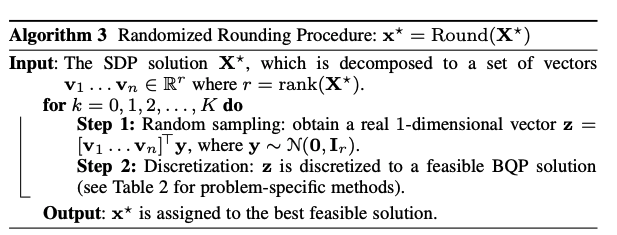

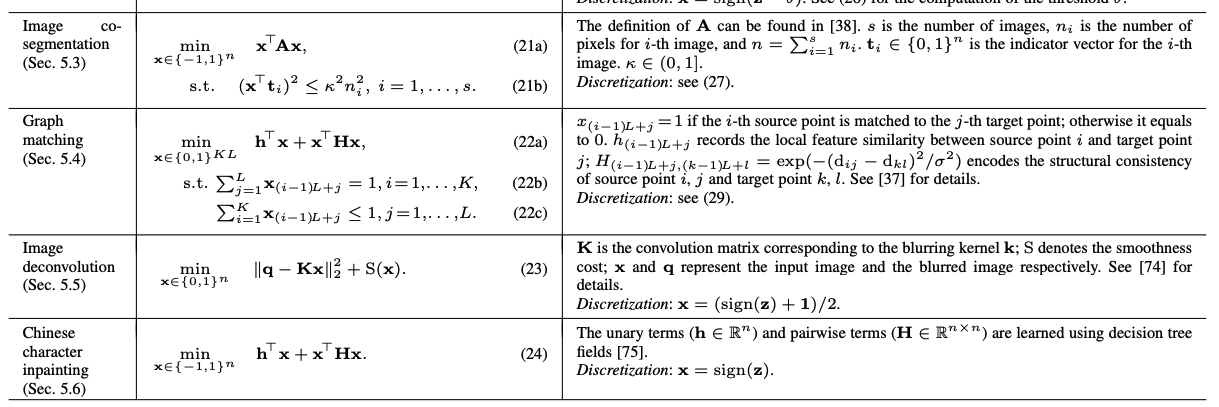

- [Source 2](https://proceedings.neurips.cc/paper/2016/file/4de754248c196c85ee4fbdcee89179bd-Paper.pdf)

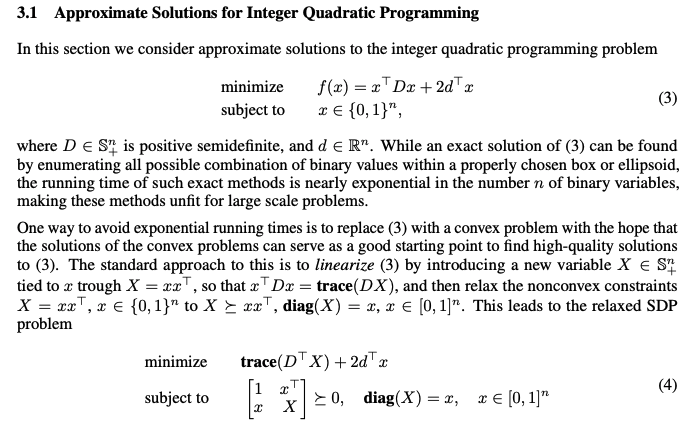

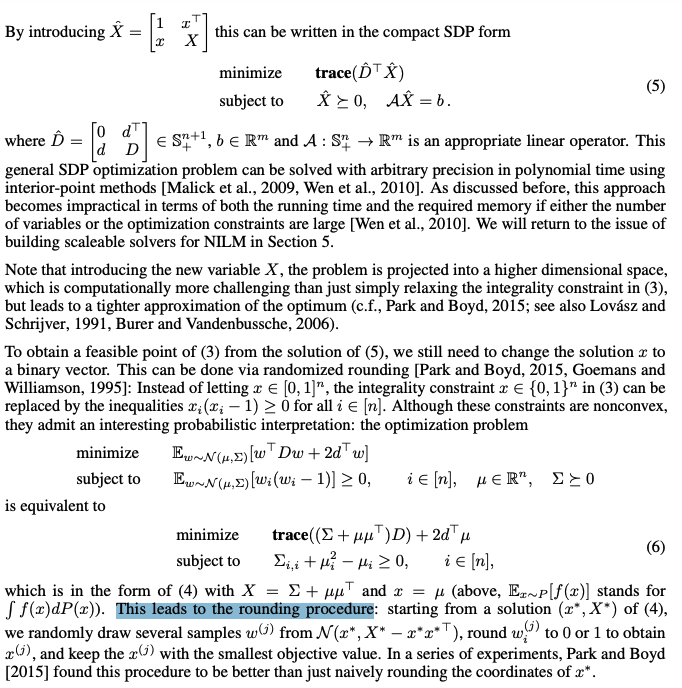

- [Source 3](https://arxiv.org/pdf/1504.07672.pdf)

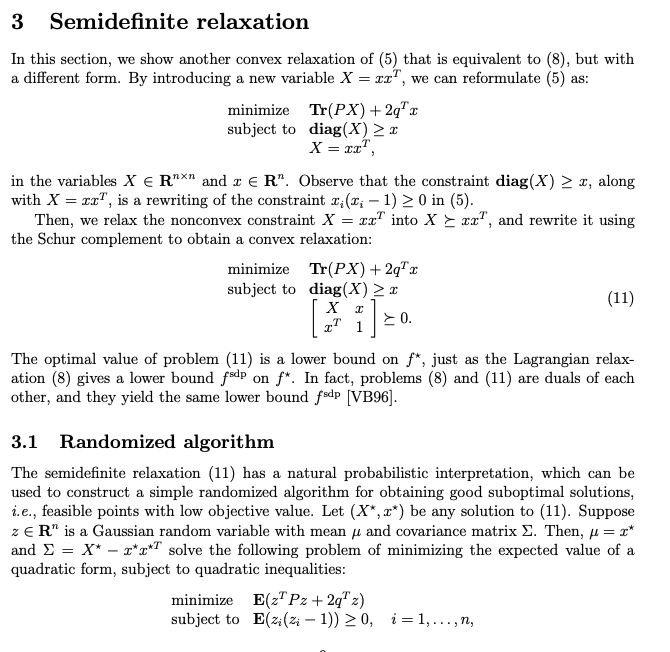

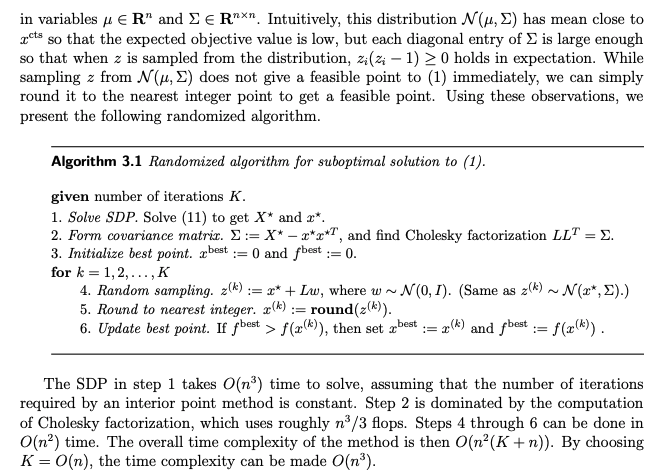

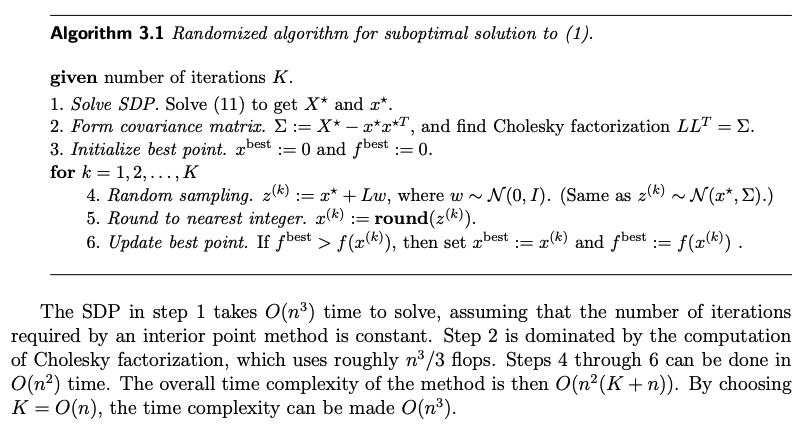

- [Source 4](https://resources.mpi-inf.mpg.de/departments/d1/teaching/ws13/Approx/lec8.pdf)

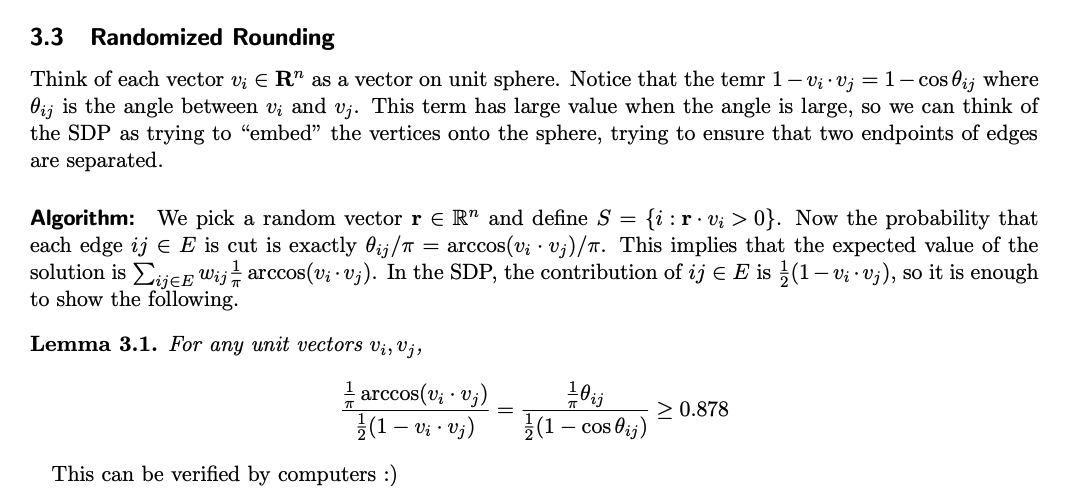

- [Source 5](https://openaccess.thecvf.com/content_cvpr_2013/papers/Wang_A_Fast_Semidefinite_2013_CVPR_paper.pdf)

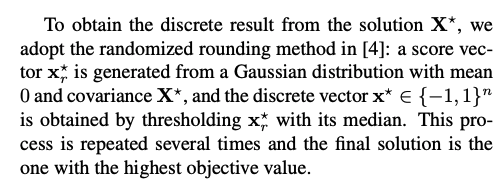

- [Source 6](https://courses.cs.washington.edu/courses/cse522/05au/charikargrothendieck.pdf)

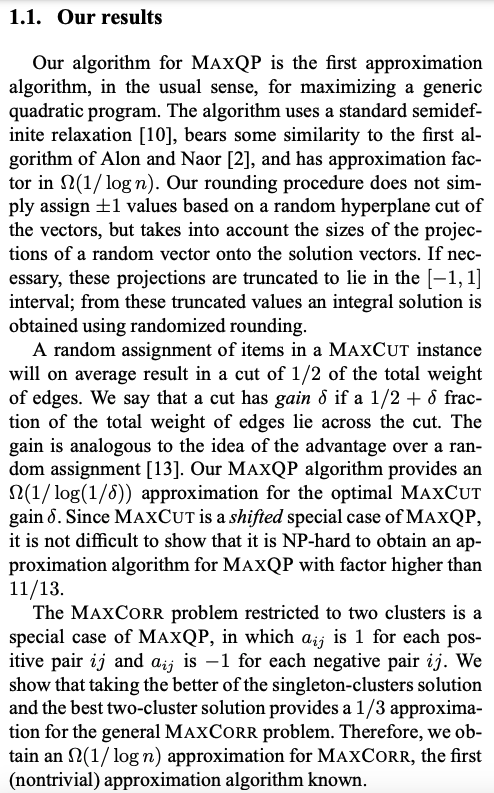

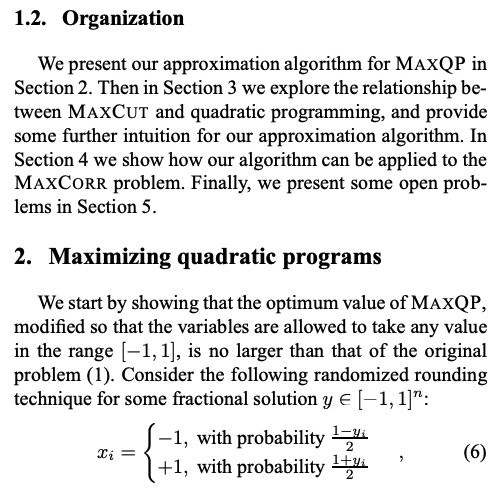

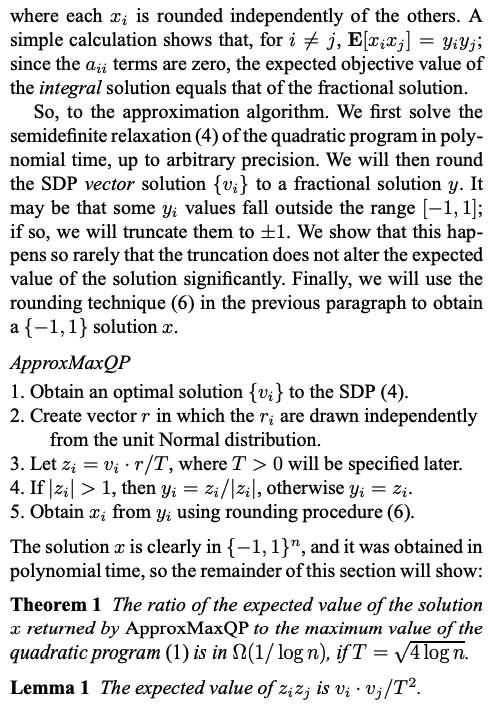

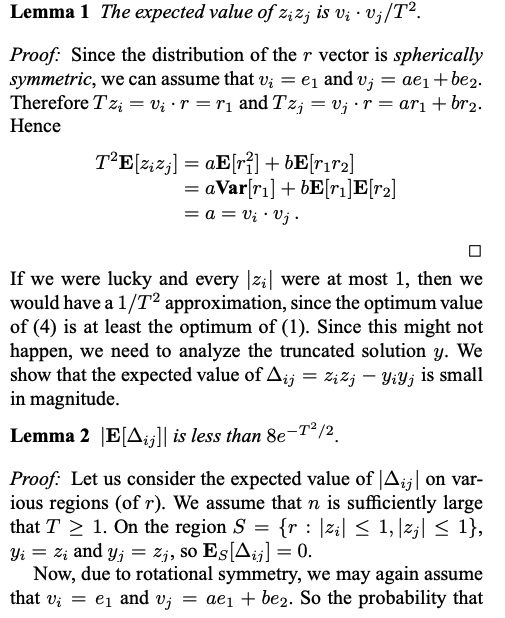

In [ ]:
# 
L = np.eye(d+1); L

# model
model_vect = np.zeros((n_vars,n_rand_vector))
obj_vect   = np.zeros(n_rand_vector)

for kk in range(n_rand_vector):
    # Generate a random cutting plane vector (unif. on sphere : U(S_{n}))
    r = np.random.randn(n_vars+1)
    r = r/np.linalg.norm(r)
    # r/=np.linalg.norm(r) # better
    y_soln = np.sign(np.dot(L.T,r))

    # convert solution to original domain and assign to output vector
    model_vect[:,kk] = (y_soln[:n_vars]+1.)/2.
    obj_vect[kk] = np.dot(np.dot(model_vect[:,kk].T,A),model_vect[:,kk]) + np.dot(b,model_vect[:,kk])
    
    # Find optimal rounded solution
    opt_idx = np.argmin(obj_vect)
    model = model_vect[:,opt_idx]
    obj   = obj_vect[opt_idx]

## `BOCS` class below

In [222]:
class BOCS:
    variantList = ['SDP', 'SA']
    optModes = ['min', 'max']
    
    def __init__(self, variant:str='SDP', oracle:Oracle=None, N:int=1, B:int=0, T:int=1, seed:int=0,
                 lambd:float=0.5, pen_ord:int=2, mode:str='min'):
        
        assert variant in self.variantList, f"AFO `variant` must be in: {', '.join(variantList)}"
        
        self.variant = variant
        self.N = N
        self.seed = seed
        self.B = B
        self.T = T
        self.lambd = lambd
        self.pen_ord = pen_ord
        self.mode = mode
        self.oracle = oracle
        
        # init Sparse Bayesian Regression
        self.BayReg = SparseBayesReg(N_total=self.N, burnin=self.B, thinning=self.T, seed=self.seed)
        
    def fit(self, X:np.array, y:np.array) -> None:
        '''
        Delegate fit to bayesian regression model
        '''
        self.BayReg.setXy(X,y)
        self.BayReg.fit(X,y)
        
    def update(self,):
        '''
        Sample alpha from Bayesian regression, solve SDP, return cancidate x & (noisy) oracle function value y
        '''
        alpha_t = self.BayReg.sampleAlpha()
        
        # SDP update
        if(self.variant=='SDP'):
            self.sdp = SDP(alpha=alpha_t, lambd=self.lambd, pen_ord=self.pen_ord, mode=self.mode)
            x_new, y_new_hat = self.sdp.run()
            y_new = self.oracle.f(x_new)
        elif(self.variant=='SA'):
            pass
        else:
            assert False, "Not implemented"
        
        # update model
        self.BayReg.add(x_new, y_new)
        
        return x_new, y_new
    
class RandomSearch():
    d_MAX = 20
    
    def __init__(self, oracle:Oracle, d:int, seed:int=0):
        assert isinstance(d, int) and 0<d<self.d_MAX, f"Dimension `d` must be non-negative integer smaller than {self.d_MAX}"
        
        self.oracle = oracle
        self.d = d
        self.seed = seed
        
        np.random.seed(self.seed)
    
    def update(self,):
        '''
        Sample random x (& noisy oracle function value) y
        '''
        x_new = np.random.binomial(n=1, p=0.5, size=self.d)
        y_new = self.oracle.f(x=x_new)
        return x_new, y_new
    

In [194]:
sa1 = SA(oracle=orc1, N=50, d=6, Tfac=0.8, mode='min')

X, y = sa1.run()
y

NameError: name 'SA' is not defined

In [ ]:
rndIndex = np.random.randint(self.d)

In [ ]:
# Frequentist Version
# - - - - - - - - - - -
# Problem
d  = 10
n  = 20
n1 = 100

#
dictBOCS = {}
dictRND = {}
for j in range(100): 
    try:
        # oracle
        np.random.seed(16*j+600)
        coef = np.random.normal(loc=0, scale=5, size=1+d+math.comb(d,2))
        orc1 = Oracle(fun= lambda x: sum([coef[i] * x[i] for i in range(len(x)-1)]), sigma_2=3.0, N_total=100_000_000)

        # D0
        np.random.seed(j)
        X = np.random.binomial(n=1,p=0.5, size=n*d).reshape((n,d))
        y = orc1.f(X)

        # BOCS
        bocs = BOCS(oracle=orc1, N=200, B=10, T=2)
        bocs.fit(X,y)

        # Random Search
        rndS = RandomSearch(oracle=orc1, d=d)

        # SMAC

        # L2S-DISCO

        BocsfList = [0]
        RndList = [0]
        for i in range(n1):
            # BOCS
            x_, y_ = bocs.update()
            BocsfList.append(min(y_, min(BocsfList)))

            # Random Search
            x_, y_ = rndS.update()
            RndList.append(min(y_, min(RndList)))

        # re-scale
        y_MAX = max(max(BocsfList), max(RndList))
        y_MIN = min(min(BocsfList), min(RndList))

        # update
        BocsfList = BocsfList / (y_MAX - y_MIN)
        RndList = RndList / (y_MAX - y_MIN)

        # update
        dictBOCS[j] = BocsfList
        dictRND[j]  = RndList
    except:
        pass



In [ ]:
# RANGE
y_MAX = max(max(BocsfList), max(RndList))
y_MIN = min(min(BocsfList), min(RndList))

# update
BocsfList = BocsfList / (y_MAX - y_MIN)
RndList = RndList / (y_MAX - y_MIN)

# Plot
plt.plot(BocsfList / (y_MAX - y_MIN), color='darkblue')
plt.plot(RndList / (y_MAX - y_MIN), color='orange')
plt.show()

In [ ]:
# Plot
fig,ax = plt.subplots()
x_ = np.array(range(30, 131))
  
mult, inter = 100, 1
q1,q2 = 0.35, 0.65
q10, q90 = 0.25, 0.75
    
# mean
y_mean  = ((np.array(pd.DataFrame(dictRND).quantile(0.5, axis=1)))+inter)*mult
ax.plot(x_, y_mean, '--', color='tab:orange')

#plt.plot(range(20, 20+len(mseDict[0])), [mse_**2 for mse_ in mse])
plt.xticks()

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictRND).quantile(q10, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictRND).quantile(q90, axis=1))+inter)*mult
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictRND).quantile(q1, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictRND).quantile(q2, axis=1))+inter)*mult
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictBOCS).quantile(q10, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictBOCS).quantile(q90, axis=1))+inter)*mult
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# compute upper lower
y_mean  = (np.array(pd.DataFrame(dictBOCS).quantile(0.5, axis=1))+inter)*mult
ax.plot(x_, y_mean, '--', color='tab:blue')
y_lower = (np.array(pd.DataFrame(dictBOCS).quantile(q1, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictBOCS).quantile(q2, axis=1))+inter)*mult
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# ticks
plt.suptitle('Effectiveness of BOCS', fontsize=16, y=0.99)
plt.title(r'$p=56, \; \; \Vert \alpha \Vert_{0}=p, \; \; n_{init}=30, \;\; \sigma^{2}=3.0, \; \; N=100, \; \; B = 50, \; T=4$', fontsize=10)
plt.xlabel(r'$n$', fontsize=14)
#plt.yscale("log") 
plt.ylim(-10,100)
plt.ylabel(r'$f(x_{t})$', fontsize=14)
plt.legend({'Rnd.Search' : 'Random', 'BOCS-SDP' : 'BOCS-SDP'})
#plt.axhline(y=0.06, linestyle='--', c='grey', linewidth=0.75, xmin=0.05, xmax=0.95)
#plt.text(s=r'$\sigma^{2} tr((X^{\top} X )^{-1})$', y=0.06, x=-26, fontsize=8, c='#525252')

plt.show()

In [ ]:
class SMAC():
    d_MAX = 20
    
    def __init__(self, oracle:Oracle, d:int, seed:int=0):
        assert isinstance(d, int) and 0<d<self.d_MAX, f"Dimension `d` must be non-negative integer smaller than {self.d_MAX}"
        
        self.oracle = Oracle
        self.d = d
        self.seed = seed
        
        np.random.seed(self.seed)
    
    def update(self,):
        '''
        Sample random x (& noisy oracle function value) y
        '''
        return np.random.binomial(n=1, p=0.5, size=self.d)
        
        

In [ ]:
from bo_opt import *

In [ ]:
# Oracle
coef = np.random.normal(loc=0, scale=5, size=1+d+math.comb(d,2))
orc1 = Oracle(fun= lambda x: sum([coef[i] * x[i] for i in range(len(x)-1)]), 
              sigma_2=3.0, 
              N_total=100_000)

# BOCS
bocs = BOCS(oracle=orc1, N=200, B=10, T=2)

# initial D_{0}
X = np.random.binomial(n=1,p=0.5, size=n*d).reshape((n,d))
y = orc1.f(X)

# fit BOCS on initial data
bocs.fit(X,y)

# - let BOCS explore
for k in range(10):
    x_new, y_new = bocs.update()